## Experiment Class Definition
- Helper class that defines the functions common to all model training(time series)

In [1]:
%%writefile experiment.py
import numpy as np
import time
import torch
from torch import nn
from utils.timeserie import split_sequence
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
#
from utils.ml import SimpleDataset, TransformerDataset
from utils.plot import plot_train_history, plot_predictions
from utils.m4 import deseasonalize, detrend, smape
# Transformers
from utils.ml import make_batches
from utils.plot import generate_square_subsequent_mask
#
class Experiment():

    def __init__(self, config: dict):
        # Set experiment config
        expected_vars = ['model','input_len','feature_dim','frequency',
                         'device','scaler','verbose','freq','decompose',
                         'forecast_horizon']
        for v in expected_vars:
            assert v in config.keys(), f'Key "{v}" is missing on params dict'
            vars(self)[v] = config[v]
        self.config = config
        #
        # Pre-configuration (to produce same result in inference/predict)
        #
        np.random.seed(7); torch.manual_seed(7)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(7)
        #
        #
        #
        self.model = self.model.to(self.device)
        self.validation_dataset = None
        self.train_dataset = None

    def split_chunks(self, linear_serie, expand_dim=True):
        x, y = split_sequence(linear_serie, self.input_len)
        x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        if expand_dim:
            x, y = x.unsqueeze(-1), y.unsqueeze(-1)
        return x, y
    
    def ts_transform(self, ts, train=False):
        # de-sazonality
        if train: # calculate
            if self.verbose: print('Decomposition FIT')
            self.seasonality_in = deseasonalize(ts, self.freq)
        for i in range(0, len(ts)):
            ts[i] = ts[i] * 100 / self.seasonality_in[i % self.freq]

        # de-trending
        if train: # calculate
            self.a, self.b = detrend(ts)   
        for i in range(0, len(ts)):
            ts[i] = ts[i] - ((self.a * i) + self.b)
        
        return ts

    def ts_inverse_transform(self, ts):
        # add trend
        for i in range(0, len(ts)):
            ts[i] = ts[i] + ((self.a * i) + self.b)
        # add seasonality
        for i in range(0, len(ts)):
            ts[i] = ts[i] * self.seasonality_in[i % self.freq] / 100
        
        return ts
    
    def set_dataset(self, linear_serie, train=False, validation=False):
        linear_serie = linear_serie.copy()
        if self.decompose:
            linear_serie = self.ts_transform(linear_serie, train)

        if self.scaler is not None:
            if train: # FIT Scaler
                linear_serie = self.scaler.fit_transform(linear_serie.reshape(-1,1)).reshape(-1)
                if self.verbose: print('Scaler FIT')
                
            if validation:
                linear_serie = self.scaler.transform(linear_serie.reshape(-1,1)).reshape(-1)
        
        # transformer specific input shape
        if self.model.is_transformer():
            enc_x, dec_x, tgt_y = make_batches(linear_serie, 
                                               self.input_len, self.forecast_horizon)
            enc_x, dec_x, tgt_y = enc_x.to(self.device), dec_x.to(self.device), tgt_y.to(self.device)
            data = TransformerDataset(enc_x, dec_x, tgt_y)
        else: # naive, cnn, mlp, lstm, 
            x, y = self.split_chunks(linear_serie)
            x, y = x.to(self.device), y.to(self.device)
            data = SimpleDataset(x, y)
        # Save
        if train:
            self.train_dataset = data
        if validation:
            self.validation_dataset = data
        
        return data

    def train(self, train_conf):
        train_conf['train_dataset'] = self.train_dataset
        train_conf['validation_dataset'] = self.validation_dataset
        self.model.fit(train_conf)
    
    def train_history(self, offset=0):
        plot_train_history(self.model.train_loss_history, self.model.validation_loss_history, offset)
    
    def preprocess(self, ts): # from numpy to torch
        ts = np.asarray(ts, dtype=np.float32).copy()
        if self.decompose:
            ts = self.ts_transform(ts, train=False)
        if self.scaler is not None:
            ts = self.scaler.transform(ts.reshape(-1,1)).reshape(-1)
        ts = torch.tensor(ts, dtype=torch.float32)\
                                .view(1,-1, 1).to(self.device)
        return ts

    def posprocess(self, ts): # from torch to numpy
        ts = ts.to('cpu').detach().numpy()
        if self.scaler is not None:
            ts = self.scaler.inverse_transform(ts.reshape(-1,1)).reshape(-1)
        if self.decompose:
            ts = self.ts_inverse_transform(ts)
        # ts = ts.to(self.device)
        return ts.flatten()

    def predict(self, ts, forecast_horizon):
        # assert(len(ts) == self.input_len) 
        ts = self.preprocess(ts) # TODO add ts copy 
        output = self.model.predict(ts, self.input_len, forecast_horizon)
        # rescale and add trend, etc..
        output = self.posprocess(output)
        return output
    
    
    def print_metrics(self, real_y, pred_y):
        mape = mean_absolute_percentage_error(real_y, pred_y)
        err_smape = smape(real_y, pred_y)
        mse = mean_squared_error(real_y, pred_y)
        print(f'MSE: {mse:.4f} | MAPE: {mape:.4f} | sMAPE: {err_smape:.4f}')


Overwriting experiment.py


---
#### SimpleTransformer (Local)

Scaler FIT
Epoch 1/512 [2.010secs] -> Train loss: 1.03706 | Validation loss: 1.01425
Epoch 2/512 [1.581secs] -> Train loss: 1.03249 | Validation loss: 1.01030
Epoch 3/512 [1.603secs] -> Train loss: 1.02612 | Validation loss: 1.00635
Epoch 4/512 [1.584secs] -> Train loss: 1.02221 | Validation loss: 1.00238
Epoch 5/512 [1.584secs] -> Train loss: 1.02143 | Validation loss: 0.99840
Epoch 6/512 [1.611secs] -> Train loss: 1.01542 | Validation loss: 0.99440
Epoch 7/512 [1.601secs] -> Train loss: 1.01225 | Validation loss: 0.99039
Epoch 8/512 [1.606secs] -> Train loss: 1.00965 | Validation loss: 0.98636
Epoch 9/512 [1.598secs] -> Train loss: 1.00177 | Validation loss: 0.98230
Epoch 10/512 [1.595secs] -> Train loss: 1.00040 | Validation loss: 0.97823
Epoch 11/512 [1.608secs] -> Train loss: 0.99424 | Validation loss: 0.97414
Epoch 12/512 [1.576secs] -> Train loss: 0.99119 | Validation loss: 0.97003
Epoch 13/512 [1.596secs] -> Train loss: 0.98575 | Validation loss: 0.96590
Epoch 14/512 [1.585secs

KeyboardInterrupt: 

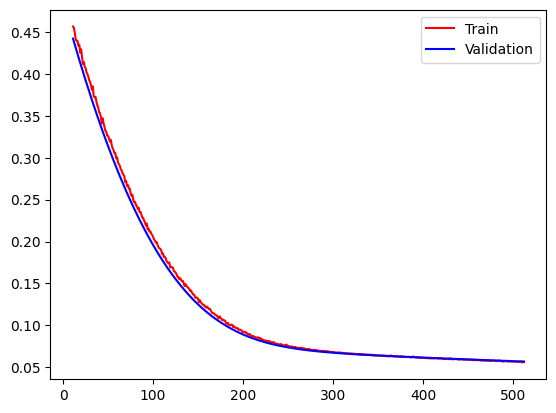

In [ ]:
plot_train_history(exp.model.train_loss_history, exp.model.validation_loss_history, 10)


In [ ]:
last_train_values = train_set.Elec_kW.values[-input_len:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

MSE: 3806.3329 | MAPE: 4.9891 | sMAPE: 2.0000


In [ ]:
exp.train({
    'epochs':512,
    'lr':1e-5,#1e-5,
    'batch_size':512,
    'verbose':True,
})

Epoch 1/512 [1.085secs] -> Train loss: 0.05603 | Validation loss: 0.05642
Epoch 2/512 [1.094secs] -> Train loss: 0.05594 | Validation loss: 0.05622
Epoch 3/512 [1.064secs] -> Train loss: 0.05572 | Validation loss: 0.05604
Epoch 4/512 [1.061secs] -> Train loss: 0.05556 | Validation loss: 0.05585
Epoch 5/512 [1.038secs] -> Train loss: 0.05515 | Validation loss: 0.05567
Epoch 6/512 [1.043secs] -> Train loss: 0.05477 | Validation loss: 0.05547
Epoch 7/512 [1.038secs] -> Train loss: 0.05469 | Validation loss: 0.05528
Epoch 8/512 [1.032secs] -> Train loss: 0.05451 | Validation loss: 0.05508
Epoch 9/512 [1.031secs] -> Train loss: 0.05442 | Validation loss: 0.05488
Epoch 10/512 [1.013secs] -> Train loss: 0.05405 | Validation loss: 0.05468
Epoch 11/512 [0.955secs] -> Train loss: 0.05386 | Validation loss: 0.05449
Epoch 12/512 [0.968secs] -> Train loss: 0.05369 | Validation loss: 0.05431
Epoch 13/512 [0.974secs] -> Train loss: 0.05337 | Validation loss: 0.05412
Epoch 14/512 [0.967secs] -> Train 

KeyboardInterrupt: 

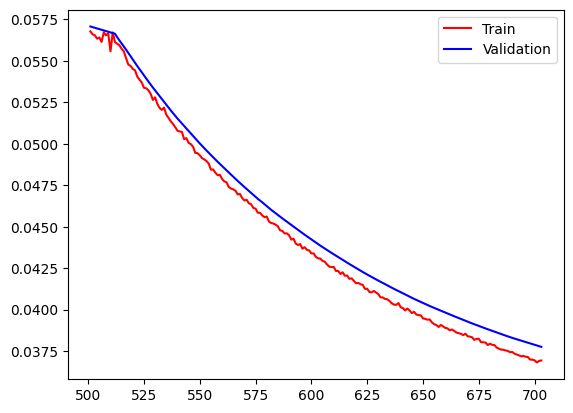

In [ ]:
plot_train_history(exp.model.train_loss_history, exp.model.validation_loss_history, 500)


In [ ]:
last_train_values = train_set.Elec_kW.values[-input_len:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

MSE: 115.3867 | MAPE: 0.7137 | sMAPE: 1.1494


In [ ]:

fh = 100
last_train_values = ts_train[-input_len:]
next_validation_values = ts_test[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(ts_train, next_validation_values, pred_y)

NameError: name 'ts_train' is not defined

In [ ]:

fh = 100
last_train_values = train_set.Elec_kW.values[-input_len:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

MSE: 828.2380 | MAPE: 1.7891 | sMAPE: 1.7096


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
input_len = 32
fh = 100
d_model = 64
model_params = {
        'in_features':1, # The number of input variables. 1 if univariate forecasting.
        'input_len':input_len,
        'max_input_len':128, # What's the longest sequence the model will encounter? Used to make the positional encoder
        'forecast_horizon':fh, # Length of the target sequence, i.e. how many time steps should your forecast cover
        'd_model':d_model, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
        'encoder_nheads':4, # The number of attention heads (parallel attention layers)
        'encoder_nlayers':2, # Number of times the layer is stacked
        'encoder_dropout': 0.1,
        'encoder_ps_dropout': 0.1,
        'feedforward_dim':8,
        'decoder_nheads':4, # The number of attention heads (parallel attention layers)
        'decoder_nlayers':2, # Number of times the layer is stacked
        'decoder_dropout': 0.1, # with zeroed dropout we can reproduce the outputs.
        'seed':7,
        'mapping_dim':8
    }

exp = Experiment(
    {
        # Model
        'model': TimeSeriesTransformer(model_params),
        'input_len':input_len,
        'feature_dim':1,
        'forecast_horizon':fh,
        # Data
        'frequency':'daily',
        'scaler':MinMaxScaler(),
        'decompose': True, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })
trend_strength = np.random.uniform(-50, 30)  # Valores aleatórios para a força da tendência
seasonal_strength = np.random.uniform(-10, 50.0)  # Valores aleatórios para a força da sazonalidade
noise_strength = np.random.uniform(-10, 20)  # Valores aleatórios para a força do ruído

ts = generate_time_series(length=1000, trend_strength=trend_strength, 
                                              seasonal_strength=seasonal_strength, noise_strength=0)
    
ts_train = ts[:500]
ts_test = ts[500:]

exp.set_dataset(linear_serie=ts_train, train=True)
exp.set_dataset(linear_serie=ts_test, validation=True)
#
def temp_train(self, conf):
    expected_vars = ['epochs','lr','batch_size','train_dataset']
    for v in expected_vars:
        assert v in conf.keys(), f'Key "{v}" is missing on params dict'
    #
    epochs = conf['epochs']
    verbose = conf['verbose']
    train_dataset = conf['train_dataset']
    val_dataset = conf.get('train_dataset',None)
    #
    optimizer = torch.optim.Adam(self.parameters(), lr=conf['lr'])
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=False)
    memory_mask, tgt_mask = self.get_train_masks()
    memory_mask, tgt_mask = memory_mask.to('cuda'), tgt_mask.to('cuda')
    for epoch_i in range(epochs):
        timr = time.time()
        epoch_loss = .0
        val_loss = -1
        for enc_x, dec_x, tgt_y in train_loader:
            optimizer.zero_grad() # current batch zero-out the loss
            pred_y = self(enc_x, dec_x, memory_mask, tgt_mask)
            loss = loss_fn(pred_y, tgt_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss        
        # end epoch
        epoch_loss = epoch_loss/len(train_loader)
        # if there are a validation set
        if val_dataset is not None:
            val_loss = self.validate(val_dataset)
            self.validation_loss_history.append(val_loss.to('cpu').detach().numpy())
        self.train_loss_history.append(epoch_loss.to('cpu').detach().numpy())
        #     
        timr = time.time() - timr
        if verbose: 
            print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f} | Validation loss: {val_loss:.5f}')

    
exp.model.fit = lambda x: temp_train(exp.model, x)

#
exp.train({
    'epochs':100,
    'lr':1e-6,#1e-5,
    'batch_size':1024,
    'verbose':True,
})
# fh = 300
# last_train_values = train_set.Elec_kW.values[-input_len:]
# next_validation_values = valid_set.Elec_kW.values[:fh]
# pred_y = exp.predict(last_train_values, fh)
# exp.print_metrics(next_validation_values, pred_y)
# #
# #
# plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

---
#### Experiment Test (CNN)

In [ ]:
from models.cnn import SimpleCNN
from models.benchmark import NaivePredictor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
INPUT_LEN = 50
exp = Experiment(
    {
        # Model
        'model': SimpleCNN(INPUT_LEN, 64),
        'input_len':INPUT_LEN,
        'feature_dim':1,
        'forecast_horizon':1,
        # Data
        'frequency':'daily',
        'scaler':StandardScaler(),
        'decompose': True, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)

exp.train({
    'epochs':100,
    'lr':1e-3,#1e-5,
    'batch_size':512,
    'verbose':False,
})
fh = 100
last_train_values = train_set.Elec_kW.values[-INPUT_LEN:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

Decomposition FIT
Scaler FIT
MSE: 10.8075 | MAPE: 0.2057 | sMAPE: 0.1778


In [ ]:
from utils.m4 import mase, smape
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# 

In [ ]:
# exp.train_history()

In [ ]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.to('cpu').detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.to('cpu').detach().numpy())
        print(f'valid_loss {valid_loss}')

In [ ]:
epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
target_x , target_y = split_sequence(train_set.Elec_kW.values,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)
inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')

model.eval()
model = model.to('cpu')
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]))
    prediction.append(preds.detach().numpy())
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()
